## Background

```
In the data supplied for this competition, the text of the individual comment is found in the comment_text column. Each comment in Train has a toxicity label (target), and models should predict the target toxicity for the Test data. This attribute (and all others) are fractional values which represent the fraction of human raters who believed the attribute applied to the given comment. For evaluation, test set examples with target >= 0.5 will be considered to be in the positive class (toxic).
```

In [1]:
# The data also has several additional toxicity subtype attributes. Models do not need to predict these attributes for the competition, they are included as an additional avenue for research. Subtype attributes are:
TOXICITY_SUBTYPES = [
    "severe_toxicity",
    "obscene",
    "threat",
    "insult",
    "identity_attack",
    "sexual_explicit"
]

In [2]:
# Additionally, a subset of comments have been labelled with a variety of identity attributes, representing the identities that are mentioned in the comment. The columns corresponding to identity attributes are listed below. Only identities with more than 500 examples in the test set (combined public and private) will be included in the evaluation calculation. These identities are shown in bold.

class IdentityAttribute:
    def __init__(self, identity, evaluated):
        self.identity = identity
        self.evaluated = evaluated

IDENTITY_ADDTRIBUTES = [
    IdentityAttribute("male", True),
    IdentityAttribute("female", True),
    IdentityAttribute("transgender", False),
    IdentityAttribute("other_gender", False),
    IdentityAttribute("heterosexual", False),
    IdentityAttribute("homosexual_gay_or_lesbian", True),
    IdentityAttribute("bisexual", False),
    IdentityAttribute("other_sexual_orientation", False),
    IdentityAttribute("christian", True),
    IdentityAttribute("jewish", True),
    IdentityAttribute("muslim", True),
    IdentityAttribute("hindu", False),
    IdentityAttribute("buddhist", False),
    IdentityAttribute("atheist", False),
    IdentityAttribute("other_religion", False),
    IdentityAttribute("black", True),
    IdentityAttribute("white", True),
    IdentityAttribute("asian", False),
    IdentityAttribute("latino", False),
    IdentityAttribute("other_race_or_ethnicity", False),
    IdentityAttribute("physical_disability", False),
    IdentityAttribute("intellectual_or_learning_disability", False),
    IdentityAttribute("psychiatric_or_mental_illness", True),
    IdentityAttribute("other_disability", False)
]        

```
In addition to the labels described above, the dataset also provides metadata from Jigsaw's annotation: toxicity_annotator_count and identity_annotator_count, and metadata from Civil Comments: created_date, publication_id, parent_id, article_id, rating, funny, wow, sad, likes, disagree. Civil Comments' label rating is the civility rating Civil Comments users gave the comment.
```

In [3]:
CIVIL_COMMENT_EMOTES = [
    "funny",
    "wow",
    "sad",
    "likes",
    "disagree"
]

CIVIL_COMMENT_METADATA = [
    "created_date",
    "publication_id",
    "parent_id",
    "article_id"
]

JIGSAW_ANNOTATIONS = [
    "toxicity_annotator_count",
    "identity_annotator_count"
]

## Initialization

In [4]:
%run jupyter/notebook_modules.ipynb

In [5]:
import ops.kaggle_dependencies

importing Jupyter notebook from /home/jupyter/kaggle-jigsaw-unintended-bias-in-toxicity-classification/ops/kaggle_dependencies.ipynb
Note: you may need to restart the kernel to use updated packages.


In [86]:
from itertools import chain, product

import kaggle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import bronze_data_preparation
import bq
from competition import THIS_COMPETITION

In [7]:
TRUNCATE_BRONZE_DATA = False

In [8]:
bronze_data_preparation.initialize(TRUNCATE_BRONZE_DATA)

## Basic Data Structure

In [9]:
kaggle.api.competition_list_files_cli(THIS_COMPETITION)

name                    size  creationDate         
---------------------  -----  -------------------  
sample_submission.csv    1MB  2019-03-28 21:16:21  
test.csv                29MB  2019-03-28 21:16:21  
train.csv              778MB  2019-03-28 21:16:18  


In [10]:
bq.query("""
SELECT * FROM {dataset_id}.train LIMIT 10
""")

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,239639,0.0,Probably because they consistently waste funds...,0.0,0.0,0.0,0.0,0.0,None,None,...,26673,approved,0,0,0,2,0,0.0,0,4
1,239690,0.0,let me some up the heavy vibers feelings:\n\nG...,0.0,0.0,0.0,0.0,0.0,None,None,...,26655,rejected,0,0,0,0,0,0.0,0,4
2,239755,0.0,What are the incidents of disrespect shown to ...,0.0,0.0,0.0,0.0,0.0,None,None,...,29795,approved,0,0,0,0,0,0.0,0,4
3,240341,0.0,"What I've always found so ironic, is that even...",0.0,0.0,0.0,0.0,0.0,None,None,...,32846,approved,0,0,0,2,0,0.0,0,4
4,240449,0.0,"Star Trek is our future, Star Wars is our past...",0.0,0.0,0.0,0.0,0.0,None,None,...,32846,approved,0,0,0,1,0,0.0,0,4
5,240489,0.0,Star Wars: Deep Space Nine is clearly the best...,0.0,0.0,0.0,0.0,0.0,None,None,...,32846,approved,0,0,0,1,0,0.0,0,4
6,240645,0.0,Do you think that treating the majority of the...,0.0,0.0,0.0,0.0,0.0,None,None,...,32516,approved,0,0,0,3,0,0.0,0,4
7,240743,0.5,The comments I see in WW today could have been...,0.0,0.4,0.3,0.3,0.0,None,None,...,33231,approved,0,0,0,3,0,0.0,0,10
8,240810,0.2,This stuff gets weirder by the day. The might...,0.0,0.0,0.1,0.1,0.1,None,None,...,33626,approved,0,0,0,0,0,0.0,0,10
9,241000,0.0,"Dear Willamette Weak,\nI am writing in regards...",0.0,0.0,0.0,0.0,0.0,None,None,...,34427,approved,0,0,0,4,0,0.0,0,4


### Validate the known fields

In [18]:
fields = (f.name for f in bq.client.get_table("{dataset_id}.train".format(dataset_id=bq.dataset_id)).schema)
known_fields = set(chain(
    ['id', 'target', 'comment_text', "rating"],
    TOXICITY_SUBTYPES,
    [i.identity for i in IDENTITY_ADDTRIBUTES],
    CIVIL_COMMENT_EMOTES,
    CIVIL_COMMENT_METADATA,
    JIGSAW_ANNOTATIONS))
assert len([u for u in fields if u not in known_fields]) == 0
    

### Validate the primary key

In [19]:
assert len(bq.query("""
    SELECT id, COUNT(*) AS c FROM {dataset_id}.train GROUP BY id HAVING c > 1
""")) == 0

## Summary Statistics

In [12]:
bq.query("""
SELECT rating, COUNT(*) FROM {dataset_id}.train GROUP BY rating
""")

,rating,f0_
0,approved,1684758
1,rejected,120116


## Univariate Analysis

In [56]:
dependent_variables = set(chain(
    ['target', 'rating'],
    TOXICITY_SUBTYPES,
    CIVIL_COMMENT_EMOTES
))

independent_variables = set(chain(
    [i.identity for i in IDENTITY_ADDTRIBUTES],
    CIVIL_COMMENT_EMOTES
))

In [60]:
# create a correlation matrix
dependent_variables_sql = ', '.join(sorted(dependent_variables))
unpivot = 'UNION ALL\n            '.join(
    '(SELECT "{v}" AS variable, {v} AS value, {dependent_variables_sql} FROM encoded)'.format(v=v, dependent_variables_sql=dependent_variables_sql)
    for v in independent_variables
)
independent_variables_sql = ', '.join('"{v}"'.format(v=v) for v in independent_latent_variables)
correlation_sql = ', '.join("CORR({d}, value) AS {d}".format(d=d) for d in sorted(dependent_variables))
correlations_df = bq.query("""

    WITH
    
        encoded AS (
            SELECT * REPLACE (
                CASE rating
                    WHEN "approved" THEN 1.0
                    WHEN "rejected" THEN 0.0
                END AS rating
            )
            FROM {{dataset_id}}.train
        ),
    
        unpivot AS (
            SELECT variable, value, {dependent_variables_sql} FROM
            {unpivot}
        )
    
    SELECT variable, {correlation_sql}
    FROM unpivot       
    GROUP BY variable
    ORDER BY variable
    
""".format(unpivot=unpivot, dependent_variables_sql=dependent_variables_sql, independent_variables_sql=independent_variables_sql, correlation_sql=correlation_sql))
correlations_df.head()

,variable,disagree,funny,identity_attack,insult,likes,obscene,rating,sad,severe_toxicity,sexual_explicit,target,threat,wow
0,asian,0.007868,-0.000409,0.041203,-0.000664,-0.003144,-0.004047,-0.007838,0.001051,0.005371,-0.013710,0.007205,-0.002817,0.010691
1,atheist,0.001031,-0.002847,0.031167,0.005152,-0.002436,-0.000122,-0.002304,0.000051,0.005047,-0.004954,0.010625,0.000781,-0.002600
2,bisexual,-0.004104,-0.003230,0.047476,0.006283,0.009078,0.005323,-0.005016,-0.002987,0.009279,0.024218,0.021057,-0.001796,-0.000367
3,black,-0.000631,-0.020852,0.314422,0.098186,-0.012769,0.026267,-0.027425,0.004480,0.094418,-0.006407,0.167224,0.048630,0.001483
4,buddhist,-0.001719,-0.002802,0.024143,-0.002909,-0.000621,-0.001751,-0.006316,-0.001348,0.004260,-0.004397,0.004613,0.002542,-0.001222


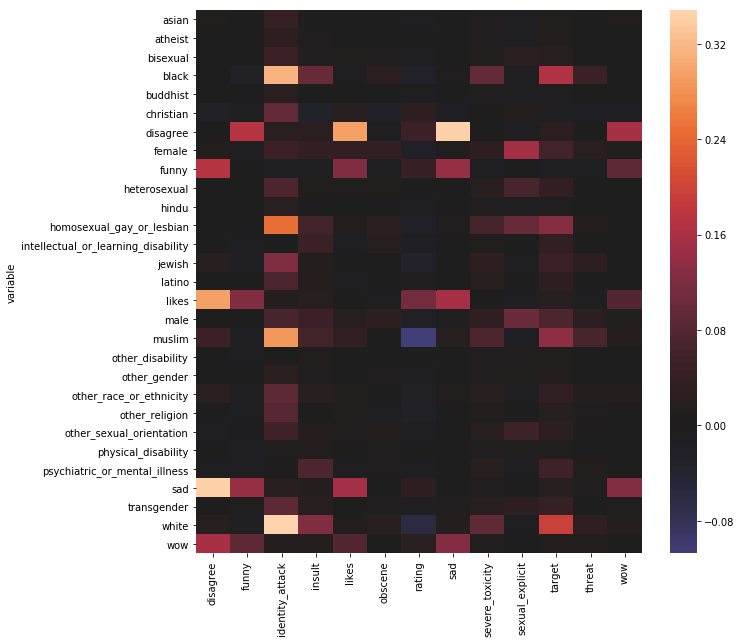

In [89]:
correlations_visualized = correlations_df.set_index("variable")
# trim out the CIVIL_COMMENT_EMOTES which are analyzed as both dependent and independent
# variables which creates skew in the correlation distribution making visualization
# difficult
for variable in CIVIL_COMMENT_EMOTES:
    correlations_visualized[variable][variable] = 0.0
plt.figure(figsize = (10,10))
sns.heatmap(correlations_visualized, center=0.0)

## Baseline Modelling